# 1. Градиентный бустинг

На этом семинаре рассматриваются продвинутые методы градиентного бустинга на примере библиотек XGBoost и CatBoost, их сравнение с классическим градиентным бустингом из scikit-learn. В качестве практического примера используется физический датасет HIGGS, связанный с обнаружением бозона Хиггса.

In [1]:
!pip install catboost
!pip install numpy==1.26.4

In [31]:
import warnings
from collections import Counter

import time

import numpy as np
import pandas as pd
from pandas import Series
from typing import List, Any, Tuple, Dict, Optional, Union
from pandas import DataFrame
from pandas.io.formats.style import Styler

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.metrics
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score

import xgboost as xgb
from xgboost import XGBClassifier, DMatrix

from catboost import CatBoostClassifier, Pool
from catboost.datasets import titanic

warnings.filterwarnings('ignore')

## 1.1 Описание датасета и подготовка данных

Будем работать с физическим датасетом HIGGS. Расскажем о нём подробнее.

**Описание HIGGS Dataset**

Физика высоких энергий посвящена изучению элементарных составляющих материи, то есть таких, которые на практике в данный момент невозможно расщепить на составные части. Например, к ним относятся фотоны, электроны, кварки, нейтрино. Всего же вместе с античастицами открыто более 350 элементарных частиц. Основными инструментами физиков-экспериментаторов являются современные ускорители, такие как Большой адронный коллайдер, в которых при столкновении протонов и/или антипротонов образуются экзотические частицы.

Подавляющее большинство столкновений частиц не приводит к появлению экзотических частиц. Например, хотя Большой адронный коллайдер производит примерно $10^{11}$ столкновений в час, в среднем около 300 из этих столкновений приводят к появлению бозона Хиггса.

> Бозон Хиггса — это элементарная частица, существование которой было предсказано ещё в 1964 году. Он играет ключевую роль в Стандартной модели физики элементарных частиц: именно взаимодействие частиц с полем Хиггса объясняет наличие у них массы. Без этого механизма фотоны, электроны и кварки вели бы себя как безмассовые частицы, и привычная нам материя попросту не могла бы существовать.
>
> Поиск бозона Хиггса длился почти 50 лет, и его открытие в 2012 году на Большом адронном коллайдере стало одним из крупнейших событий современной физики. За это открытие в 2013 году Питер Хиггс и Франсуа Энглер получили Нобелевскую премию по физике.

* [CERN: Открытие бозона Хиггса](https://home.cern/science/physics/higgs-boson)
* [Видео о том, что такое бозон Хиггса](https://youtu.be/R8a6Tb2lYB0)

Очевидно, что хранить информацию обо всех зарегистрированных столкновениях в Большом адронном коллайдере невозможно, требуется отбирать только потенциально интересные события для дальнейшего анализа. Для этого ставится задача бинарной классификации столкновений на потенциально интересные, в результате которых образуются интересующие нас частицы (сигнал) и те, в результате которых образуются другие частицы (фон). Эта задача решается в несколько этапов. На первом этапе применяются простые модели, ключевыми требованиями к которым являются высокие скорость работы и Recall — не так страшно, если через первичный отсев пройдет в 10-100 раз больше столкновений, чем нас интересуют, главное чтобы среди них были все или почти все действительно интересные. На следующих этапах применяются уже более сложные и вычислительно затраты модели, способные отделить сигнал от похожего на него шума.

Причем, даже если в столкновении образуются интересующие нас экзотические частицы, их обнаружение сопряжено со значительными трудностями. Экзотические частицы очень нестабильны и почти мгновенно распадаются на другие частицы. Например, бозон Хиггса распадается спустя примерно $1.6 \times 10^{-22}$ секунды. Таким образом оказывается, что наблюдать их напрямую не получится, но можно наблюдать за теми частицами, которые образовались в результате распада, их называют продукты распада. Всего в результате каждого столкновения могут образовываться десятки, а иногда и сотни других частиц. Для их регистрации участок ускорителя, на котором происходят все столкновения, окружается несколькими слоями детекторов, измеряющих направление, количество и энергию продуктов распада.

HIGGS Dataset создан для создания моделей машинного обучения для отделения сигналов появления бозонов Хиггса от фоновых событий уже после проведенного первичного отсева, то есть в нем нет тех столкновений, в которых бозон Хиггса не мог образоваться ни при каких обстоятельствах. На рисунке ниже показаны два вида столкновений, которые и представлены в данном датасете. В обоих случаях происходит столкновение глюонов g, а после промежуточных преобразований на выходе получаются два W-бозона и два b-кварка. Но в случае столкновения типа (a) в ходе промежуточных преобразований сначала образуется электрически нейтральный бозон Хиггса $H^0$, который распадается на W-бозон и электрически заряженный бозон Хиггса $H^±$, который, в свою очередь, также распадается на W-бозон и легкий бозон Хиггса $h^0$, который потом распадается на два b-кварка. В случае же столкновения типа (b) вместо электрически нейтрального озона Хиггса образуются два топ-кварца, каждый из которых потом распадается на W-бозон и b-кварк. Необходимо отделить столкновения типа (a) — сигнал, от событий типа (b) — фон.

Данные сгенерированы с помощью Монте-Карло симуляций столкновений протонов на LHC (Большой адронный коллайдер) при энергии 8 ТэВ. Симуляция проводилась в соответствии со Стандартной моделью, предсказания которой сходятся с экспериментом с отклонением $10^{-5}$.


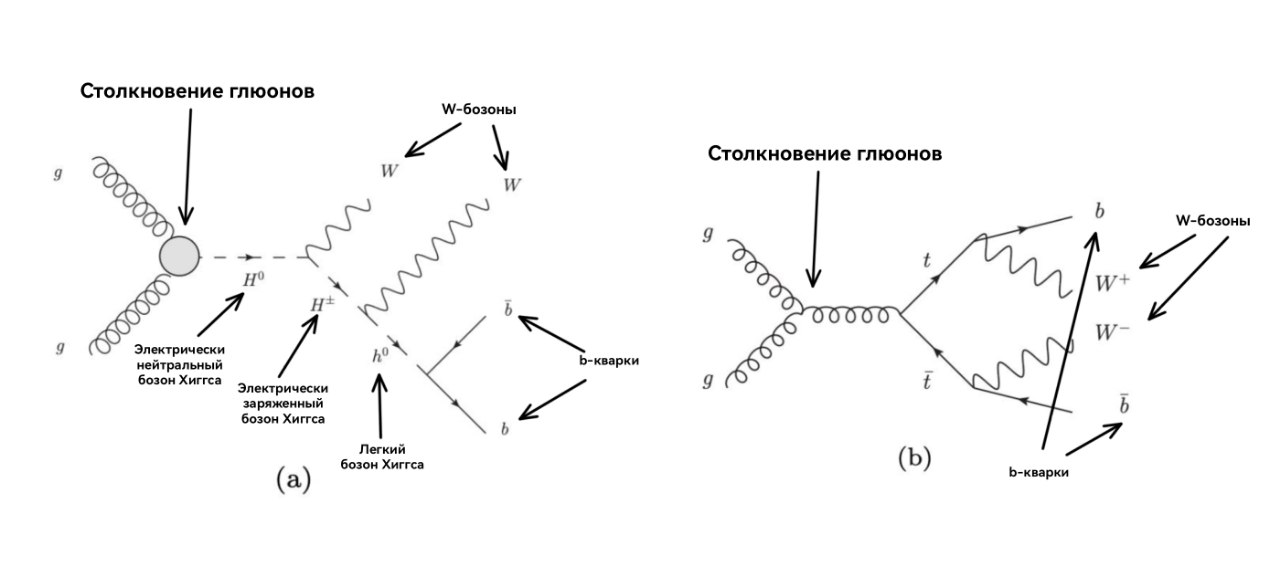
</div>

**Задача:** бинарная классификация (сигнал / шум).

**Цель:** разработать модель классификации, которая лучше всего отделяет сигнал от фона.

**Размер:** 11 миллионов строк, 28 числовых признаков. Датасет сбалансирован и содержит примерно 53% столкновений с образованием бозонов Хиггса.

**Целевая переменная** (0 столбец) имеет вид:
* 1 — событие связано c бозоном Хиггса (сигнал).
* 0 — фоновое событие (шум).

**Признаки:**
* 21 низкоуровневый признак: импульсы, углы частиц, энергия заряженных лептонов и джетов (измерены детектором).
* 7 высокоуровневых признаков: инвариантные массы промежуточных частиц (получены в результате обработки исходных данных)

**Практическая ценность:**
Позволяет ускорить поиск новых частиц — чем более точно мы можем регистрировать интересующие нас типы событий, тем более быстро накапливается статистика по ним, тем соответственно быстрее мы можем получать статистически значимые результаты.

По [ссылке](https://arxiv.org/pdf/1402.4735) можно узнать больше об этом датасете.

Объявим глобальные константы

In [5]:
RANDOM_STATE = 42

Загрузим датасет

In [11]:
# Для работы локально или в Google Colab скачайте датасет по ссылке
# url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz'
# df_higgs = pd.read_csv(url, compression='gzip', header=None)

# Для работы в Kaggle добавьте датасет HIGGS UCI DATASET в input ноутбука
path = '/kaggle/input/higgs-uci-dataset/HIGGS.csv'
df_higgs = pd.read_csv(path, header=None)

Посмотрим, как выглядит наш датасет:

In [12]:
df_higgs.head()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,1.0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,...,-0.010455,-0.045767,3.101961,1.353760,0.979563,0.978076,0.920005,0.721657,0.988751,0.876678
1,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,...,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
2,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,...,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
3,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,...,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
4,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,...,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487


Видим, что нет названий столбцов. Добавим их, взяв из статьи:

| Название признака           | Тип         | Расшифровка и смысл                                                                 |
|-----------------------------|--------------|--------------------------------------------------------------------------------------|
| `class_label`               | Целевая      | Метка класса: 1 — сигнал (бозон Хиггса), 0 — фон                                    |
| `lepton_pt`                 | Низкоуровн.  | Поперечный импульс лептона (`pt` — transverse momentum)                             |
| `lepton_eta`                | Низкоуровн.  | Псевдоскорость лептона (`eta` — pseudorapidity), описывает угол к оси пучка         |
| `lepton_phi`                | Низкоуровн.  | Азимутальный угол лептона (`phi`)                                                   |
| `missing_energy_magnitude` | Низкоуровн.  | Величина недостающей энергии (чаще всего — из-за нейтрино)                          |
| `missing_energy_phi`        | Низкоуровн.  | Направление недостающей энергии (азимутальный угол)                                 |
| `jet_N_pt` (N=1..4)         | Низкоуровн.  | Поперечный импульс N-го джета                                                       |
| `jet_N_eta` (N=1..4)        | Низкоуровн.  | Псевдоскорость N-го джета                                                           |
| `jet_N_phi` (N=1..4)        | Низкоуровн.  | Азимутальный угол N-го джета                                                        |
| `jet_N_b_tag` (N=1..4)      | Низкоуровн.  | Вероятность, что джет образован b-кварком (результат b-tagging алгоритма)           |
| `m_jj`                      | Высокоуровн. | Инвариантная масса двух джетов (`m` — mass, `jj` — два джета)                       |
| `m_jjj`                     | Высокоуровн. | Инвариантная масса трёх джетов                                                      |
| `m_lv`                      | Высокоуровн. | Инвариантная масса лептон + нейтрино (`lv`)                                         |
| `m_jlv`                     | Высокоуровн. | Инвариантная масса лептон + нейтрино + джет                                         |
| `m_bb`                      | Высокоуровн. | Инвариантная масса двух b-джетов                                                    |
| `m_wbb`                     | Высокоуровн. | Инвариантная масса системы W-бозона и двух b-джетов                                 |
| `m_wwbb`                    | Высокоуровн. | Инвариантная масса двух W-бозонов и двух b-джетов                                   |


In [13]:
column_names = [
    'class_label', 'lepton_pt', 'lepton_eta', 'lepton_phi',
    'missing_energy_magnitude', 'missing_energy_phi',
    'jet_1_pt', 'jet_1_eta', 'jet_1_phi', 'jet_1_b_tag',
    'jet_2_pt', 'jet_2_eta', 'jet_2_phi', 'jet_2_b_tag',
    'jet_3_pt', 'jet_3_eta', 'jet_3_phi', 'jet_3_b_tag',
    'jet_4_pt', 'jet_4_eta', 'jet_4_phi', 'jet_4_b_tag',
    'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb'
]

df_higgs.columns = column_names
df_higgs.head()

,class_label,lepton_pt,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet_1_pt,jet_1_eta,jet_1_phi,jet_1_b_tag,...,jet_4_eta,jet_4_phi,jet_4_b_tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,1.0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,...,-0.010455,-0.045767,3.101961,1.353760,0.979563,0.978076,0.920005,0.721657,0.988751,0.876678
1,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,...,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
2,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,...,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
3,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,...,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
4,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,...,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487


Разделим его на признаки и целевую переменную

In [14]:
X_higgs = df_higgs.iloc[:, 1:]
y_higgs = df_higgs.iloc[:, 0]

Посмотрим, какой размер имеет датасет:

In [15]:
df_higgs.shape

(11000000, 29)

Он слишком большой для обычного бустинга, оставим только 20% и обучимся на них

In [16]:
X_higgs, _, y_higgs, _ = train_test_split(X_higgs, y_higgs, test_size=0.8, random_state=RANDOM_STATE)

Разделим на трейн, валидацию и тест. В обучение берём 60% массива, а в валидацию и в тест — по 20%

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_higgs, y_higgs, test_size=0.2, random_state=RANDOM_STATE)
X_train, X_validate, y_train, y_validate = train_test_split(
    X_train, y_train, test_size=0.25, random_state=RANDOM_STATE
)

Посмотрим на размеры полученных массивов.

In [18]:
X_train.shape, X_validate.shape, X_test.shape

((1320000, 28), (440000, 28), (440000, 28))

## 1.2 Вспомогательные функции

### 1.2.1 Функции для модели

Последующие две функции напишем в обобщённом виде, чтобы мы могли их использовать и для CatBoost, и для XGBoost, и для простого градиентного бустинга.

Напишем функцию для обучения модели и подсчёта времени обучения

In [19]:
def train_model(
    model: Any,
    train_data: Union[Any, DMatrix, Pool],
    train_labels: Optional[Any] = None,
    num_boost_round: int = 20,
    obj: Optional[Any] = None,
    evals: Optional[list] = None,
    verbose_eval: bool = False,
    **kwargs
) -> Tuple[Any, float]:
    """
    Универсальная функция для обучения моделей разных библиотек.

    Параметры:
    - model: экземпляр модели. Если None и train_data — DMatrix, используется XGBoost.
    - train_data: обучающая выборка (X, DMatrix или Pool)
    - train_labels: метки классов (если не переданы через DMatrix/Pool)
    - num_boost_round: количество бустинговых итераций для XGBoost
    - obj: функция ошибки для XGBoost (опционально)
    - evals: список пар (данные, название) для оценки на валидации в XGBoost
    - verbose_eval: флаг печати промежуточных результатов XGBoost
    - **kwargs: дополнительные параметры, пробрасываемые в `.fit()` для sklearn

    Возвращает:
    - model: обученная модель
    - train_time: время обучения в секундах
    """
    start_time = time.time()

    # Обработка XGBoost
    if isinstance(train_data, DMatrix):
        model = xgb.train(
            kwargs.get('params', {}),
            train_data,
            num_boost_round=num_boost_round,
            obj=obj,
            evals=evals,
            verbose_eval=verbose_eval
        )

    # Обработка CatBoost с типом данных Pool
    elif isinstance(train_data, Pool):
        model.fit(train_data)

    # Обработка sklearn-подобных моделей
    else:
        fit_params = {}
        if 'eval_set' in kwargs:
            fit_params['eval_set'] = kwargs['eval_set']

        model.fit(train_data, train_labels, **fit_params)

    train_time = time.time() - start_time
    return model, train_time

Напишем функцию для оценки моделей, которая будет считать метрики, ошибки и время обучения и предсказания

In [32]:
def evaluate_model(
    model: Any,
    X_test: Union[Any, DMatrix, Pool],
    y_test: Optional[np.ndarray] = None
) -> Tuple[float, float, float, float, float]:
    """
    Универсальная функция для оценки качества модели.

    Параметры:
    - model: обученная модель
    - X_test: тестовые данные (может быть обычный X, DMatrix или Pool)
    - y_test: истинные метки классов (если отсутствуют — извлекаются из DMatrix/Pool)

    Возвращает:
    - pred_time: время предсказания
    - accuracy: точность
    - precision: точность положительного класса
    - recall: полнота
    - f1: f1-мера
    """
    start_time = time.time()

    # Предсказание и извлечение y_test при необходимости

    # В случае когда X_test является типом данных DMatrix
    if isinstance(X_test, DMatrix):
        y_pred_proba = model.predict(X_test)
        y_pred = (y_pred_proba > 0.5).astype(int)
        if y_test is None:
            y_test = X_test.get_label()

    # В случае когда X_test является типом данных Pool
    elif isinstance(X_test, Pool):
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        if y_test is None:
            y_test = X_test.get_label()

    # В остальных случаях
    else:
        y_pred = model.predict(X_test)
        y_pred_proba = (
            model.predict_proba(X_test)[:, 1]
            if hasattr(model, 'predict_proba') else y_pred
        )

    pred_time = time.time() - start_time

    return (
        pred_time,
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred, zero_division=0),
        recall_score(y_test, y_pred, zero_division=0),
        f1_score(y_test, y_pred, zero_division=0),
    )

&#x2757; **Интерактив** &#x2757;

> Обоснование выбора метрик:
>1. Accuracy
>2. Precision
>3. Recall
>4. F1-score
>5. ROC-AUC
>6. Confusion Matrix
>
> Подумайте, какие из метрик лучше всего подойдут для нашей задачи. Объясните, чем может быть полезна каждая из них


<details>
  <summary> Кликни для показа ответа </summary>


### 1.2.2 Обоснование выбора метрик:

---

### 1. Accuracy

Что измеряет: Долю правильно классифицированных событий.

Почему полезна:

* Датасет сбалансирован, поэтому accuracy не будет искажать реальное качество модели.
* Даёт общее представление о точности предсказаний.

Но:
* Не показывает, какие ошибки делает модель (ложные срабатывания или пропуски сигнала).

---

### 2. Precision (точность)

Что измеряет: Из всех предсказанных как "сигнал" событий, сколько действительно являются сигналом.

Почему полезна:

* Помогает уменьшить количество ложных срабатываний.
* Чем выше precision, тем более уверенно можно интерпретировать классифицированное событие как "сигнал".
* Это важно, если анализ "сигналов" требует дорогих вычислений или ручной верификации.

---

### 3. Recall (полнота)

Что измеряет: Из всех реальных "сигналов", сколько модель нашла.

Почему критически важно:

* Пропуск события, связанного с бозоном Хиггса — потеря научно ценной информации.
* Накопление статистики по таким событиям напрямую зависит от recall.
* В данной задаче, высокий recall = быстрое обнаружение редких эффектов.

---

### 4. F1-score

Что измеряет: Гармоническое среднее между precision и recall.

Почему полезна:

* Даёт сбалансированную оценку, когда оба типа ошибок важны.
* В реальной научной задаче хочется и находить сигнал, и не ошибаться часто — F1 фиксирует этот компромисс.

---


### Какую метрику выбрать?

| Сценарий                                          | Метрика              |
| ------------------------------------------------- | -------------------- |
| Хотим не пропускать сигналы                   | Recall           |
| Хотим не тратить ресурсы на шум               | Precision        |
| Нужно сбалансировать оба подхода              | F1-score         |
| Для общей статистики при сбалансированных классах | Accuracy         |

---

### Вывод:

Наиболее значимыми метриками в этой задаче являются:

* Recall — чтобы не упускать события, связанные с бозоном Хиггса.
* F1-score — чтобы сбалансировать точность и полноту.

</details><br/>

### 1.2.3 Функции для визуализации и вывода результата

Сохранять результаты будем в таблицу, чтобы сравнивать с последующими моделями

In [33]:
results_df = pd.DataFrame(columns=["Модель", "fit time, s", "pred time, s", \
                                   "Accuracy", "Precision", "Recall", "F1-score"])

Будем выделять лучшие метрики зелёным

In [22]:
def highlight_best(series: pd.Series) -> List[str]:
    """
    Подсвечивает лучшие значения в столбце:
    - минимальные для времени;
    - максимальные для метрик.
    Игнорирует столбец 'Модель' и строковые 'nan'.

    Возвращает:
    - Список CSS-стилей для каждой ячейки.
    """
    if series.name == 'Модель':
        return [''] * len(series)

    # Преобразование к числам, замена строковых 'nan'
    try:
        numeric_series = pd.to_numeric(series.replace(["nan", "NaN"], np.nan))
    except Exception:
        return [''] * len(series)

    if numeric_series.isnull().all():
        return [''] * len(series)

    # Выбор лучшего значения
    best_value = numeric_series.min() if series.name in ["fit time, s", "pred time, s"] else numeric_series.max()
    return [
        'background-color: lightgreen' if val == best_value else ''
        for val in numeric_series
    ]

Добавим ещё чёрные рамки для удобства. Применим стиль к таблице и округлим предсказания.

In [23]:
def visualize_metric_df(
    df: pd.DataFrame,
    precision: int = 4
) -> pd.io.formats.style.Styler:
    """
    Визуализирует таблицу метрик с округлением, чёрными рамками и подсветкой лучших значений.

    Параметры:
    - df: DataFrame с метриками
    - precision: количество знаков после запятой

    Возвращает:
    - pandas Styler: стилизованная таблица
    """
    df_rounded = df.copy()
    numeric_cols = df_rounded.select_dtypes(include=["float64", "int64"]).columns

    df_rounded[numeric_cols] = df_rounded[numeric_cols].astype(float).round(precision)
    for col in numeric_cols:
        df_rounded[col] = df_rounded[col].apply(lambda x: f"{x:.{precision}f}")

    return (
        df_rounded
        .style
        .set_table_styles([{
            "selector": "td, th",
            "props": [("border", "1px solid black")]
        }])
        .apply(highlight_best, axis=0)
    )

Так будем смотреть на таблицу с применением стиля

In [24]:
visualize_metric_df(results_df)

,Модель,"fit time, s","pred time, s",Accuracy,Precision,Recall,F1-score


Ещё напишем функцию для визуализации матрицы ошибок. Для удобства интерпретации она будет отображать результаты в процентах.

In [34]:
def evaluate_and_store(
    model_name: str,
    model: Any,
    X_test: Any,
    y_test: Any,
    train_time: float,
    results_df: pd.DataFrame,
    class_names: List[str] = ["Фон", "Сигнал"],
    precision: int = 4
):
    """
    Выполняет оценку модели, сохраняет метрики в results_df, визуализирует таблицу и confusion matrix.

    Параметры:
    - model_name: имя модели
    - model: обученная модель
    - X_test, y_test: тестовые данные
    - train_time: время обучения
    - results_df: таблица с результатами (будет обновлена)
    - class_names: подписи классов для матрицы ошибок
    - precision: точность округления при визуализации таблицы
    """
    # Получаем все метрики в виде списка
    metrics = evaluate_model(model, X_test, y_test)  # функция возвращает список [pred_time, acc, prec, rec, f1, roc_auc, cm]

    # Записываем результаты в DataFrame
    results_df.loc[len(results_df)] = [model_name, train_time] + list(metrics)  # Исключаем cm (матрицу ошибок) из записи в таблицу

    # Отображаем результаты метрик
    display(visualize_metric_df(results_df, precision))

Теперь у нас есть все функции, чтобы далее применять модели и видеть метрики

## 1.3 Применение градиентного бустинга

Обучим наш градиентный бустинг на этом датасете

In [26]:
model = GradientBoostingClassifier(
    n_estimators=100,   # Количество деревьев
    learning_rate=0.1,  # Скорость обучения
    max_depth=3,        # Максимальная глубина деревьев
    random_state=RANDOM_STATE
)

model, train_time_gbc = train_model(model, X_train, y_train)

Добавим в таблицу нашу первую модель — обычный бустинг. Посмотрим метрики на тестовом пуле, а также визуализируем матрицу ошибок с процентами верно угаданных значений и ошибок.

In [35]:
evaluate_and_store("Обычный бустинг", model, X_test, y_test, train_time_gbc, results_df)

,Модель,"fit time, s","pred time, s",Accuracy,Precision,Recall,F1-score
0,Обычный бустинг,1675.0494,2.2528,0.7142,0.7250,0.7413,0.7331


Теперь посчитаем в минутах, сколько времени потребовалось модели:

In [36]:
print(f'Время обучения в минутах: {train_time_gbc / 60:.2f}')

Время обучения в минутах: 27.92


Потребовалось около 30 минут, чтобы обучиться только на 20% датасета :(

Но есть решение! &#x2728; &#x2728; &#x2728;

✍ **Теперь перейдём к лекционной части и узнаем, как можно ускорить градиентный бустинг.**

# 2. Градиентный бустинг на решающих деревьях

Бустинг &mdash; один из самых широко применяемых видов ансамблей моделей. В данном ноутбуке будут разобраны библиотеки `XGBoost` и `CatBoost`.

Материалы по теме:
- [XGBoost](https://github.com/dmlc/xgboost) &mdash; eXtreme Gradient Boosting;
- [CatBoost](https://github.com/catboost/catboost);
- [Сравнение библиотек (CatBoost vs. Light GBM vs. XGBoost)](https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db).

## 2.1 XGBoost

В библиотеке XGBoost есть два способа построения моделей:

1. **Нативный интерфейс** — с использованием классов `DMatrix` для хранения данных и функции `xgb.train` для обучения модели. Этот вариант даёт доступ ко всем внутренним возможностям XGBoost и часто используется в соревновательных решениях.

2. **sklearn-like обёртка над нативным интерфейсом** — классы `XGBRegressor` и `XGBClassifier`, которые реализуют стандартные методы `fit`, `predict` и совместимы с утилитами библиотеки `scikit-learn`, такими как `GridSearchCV` или `cross_val_score`.

Благодаря второму варианту XGBoost легко интегрируется в привычный ML-пайплайн на базе sklearn, так что начнём с него

### 2.1.1 `sklearn`-интерфейс

Обучим `XGBClassifier`

In [37]:
xgb_model = XGBClassifier(
    max_depth=3,
    n_estimators=100,
    random_state=RANDOM_STATE,
    verbosity=0
)

xgb_model, train_time_xgb = train_model(xgb_model, X_train, y_train)

Для него аналогично предскажем все метрики, добавим в таблицу и посмотрим на результаты

In [38]:
evaluate_and_store("XGBClassifier", xgb_model, X_test, y_test, train_time_xgb, results_df)

,Модель,"fit time, s","pred time, s",Accuracy,Precision,Recall,F1-score
0,Обычный бустинг,1675.0494,2.2528,0.7142,0.7250,0.7413,0.7331
1,XGBClassifier,9.3885,0.4794,0.7228,0.7326,0.7503,0.7413


Видим, что потребовалось в разы меньше времени, чтобы получить результаты более хорошие по всем метрикам. В том числе и на confusion matrix видим, что и ложноположительных, и ложноотрицательных результатов стало меньше.

### 2.1.2 Нативный интерфейс

У `XGBoost` также есть свой нативный интерфейс, и `sklearn`-интерфейс использует его внутри себя.

**Преимущества:**
1. Можно использовать пользовательские функции потерь и метрики (увидим далее).
2. Позволяет эффективно работать с памятью, поскольку DMatrix формат оптимизирован для XGBoost.
3. Продвинутые возможности обучения. Позже можно продолжить обучение модели, а также есть callback функции для мониторинга.
4. Детальный контроль валидации.
5. Производительность на больших данных.

Переход из `sklearn`-интерфейса в нативный осуществляется с помощью метода `get_booster()`:

In [39]:
native_xgb_model = xgb_model.get_booster()

> Для хранения данных в нативном интерфейсе используется класс `xgboost.DMatrix`. Он хранит в себе:
>   - `data` &mdash; матрица объект-признак;
>   - `label` &mdash; вектор с таргетом (для обучения и валидации);
>   - `weight` &mdash; вектор весов объектов;
>   - `feature_names` &mdash; названия признаков.
>   
> Данные можно легко перевести в объект `DMatrix` из `csv`-файла, `numpy`-массива и `pandas`-датафрейма.
>
> В конструктор `DMatrix` можно передать следующие дополнительные параметры:
>   - `weight` &mdash; инициализация весов модели;
>   - `missing` &mdash; константа для заполнения пропущенных значений.

In [40]:
xgtrain = DMatrix(X_train, label=y_train)
xgtest = DMatrix(X_test, label=y_test)

> Функция `xgboost.train()` используется для обучения модели `XGBoost`. Она:
>
> 1. Принимает на вход:
>
>    * объект `DMatrix` — специальный формат данных для `XGBoost`;
>    * словарь `params` с гиперпараметрами модели;
>    * дополнительные аргументы (например, количество итераций обучения, функция потерь, early stopping и др.).
>
> 2. Возвращает объект класса `xgboost.Booster` — это обученная модель.
>
> 3. У объекта `Booster` есть метод `predict()`, который позволяет делать предсказания на новых данных (также в формате `DMatrix`).
>
> 📌 [Документация xgboost.train()](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.train)

In [41]:
params = {
    'objective': 'binary:logistic',  # Функция потерь (можно оставить стандартную)
    'booster': 'gbtree',             # Используем деревья
    'eval_metric': 'logloss',        # Метрика для оценки (логарифмическая потеря)
    'max_depth': 3,                  # Максимальная глубина деревьев
    'tree_method': 'hist',           # Метод построения деревьев - узнаем о нём подробнее далее
    'silent': True,                  # Отключение вывода логов
    'random_state': RANDOM_STATE     # Для воспроизводимости
}

bst, train_time = train_model(
    None,  # Параметр для scikit-learn API - None означает использование нативного XGBoost API
    xgtrain,  # Данные в формате DMatrix XGBoost
    params=params,  # Словарь с гиперпараметрами модели
    num_boost_round=20  # Количество деревьев (итераций бустинга) для построения
)

### 2.1.3 Своя функция потерь

В `XGBoost` имеется возможность реализовать свои метрики и функции потерь. Для функций потерь необходимо уметь считать градиент и гессиан (точнее, его главную диагональ).

Определим свою функцию потерь.

In [42]:
def my_xgb_log_loss(preds: np.ndarray, dtrain: xgb.DMatrix) -> Tuple[np.ndarray, np.ndarray]:
    '''
    Реализация логистической функции потерь (Log Loss) для XGBoost.

    Параметры:
    - preds — предсказания (логиты)
    - dtrain — обучающий датасет с истинными метками

    Возвращает:
    - grad — градиенты
    - hess — диагональные элементы гессиана
    '''
    # Извлекаем истинные метки классов
    labels = dtrain.get_label()

    # Преобразуем предсказания в вероятности с помощью сигмоиды
    preds = 1 / (1 + np.exp(-preds))

    # Градиент функции потерь по ответам
    grad = preds - labels

    # Вторые производные (диагональные элементы гессиана)
    hess = preds * (1 - preds)

    return grad, hess

Обучим нашу модель, используя свою функцию потерь.

In [43]:
xgtrain = xgb.DMatrix(X_train, label=y_train,
                      feature_names=column_names[1:])
xgvalidate = xgb.DMatrix(X_validate, label=y_validate,
                         feature_names=column_names[1:])
xgtest = xgb.DMatrix(X_test, label=y_test,
                     feature_names=column_names[1:])

In [44]:
print('Вывод при обучении:')
bst, train_time = train_model(
    None,  # Для нативного XGBoost передаем None
    xgtrain,
    params=params,
    num_boost_round=100,
    obj=my_xgb_log_loss,
    evals=[(xgvalidate, 'validate'), (xgtest, 'test')],
    verbose_eval=50 # Печатать результат через каждые 50 итераций
)
print('\n\nРезультат на тестовых данных:\n', bst.eval(xgtest))

Вывод при обучении:
[0]	validate-logloss:0.66470	test-logloss:0.66461
[50]	validate-logloss:0.54971	test-logloss:0.54783
[99]	validate-logloss:0.54147	test-logloss:0.53966


Результат на тестовых данных:
 [0]	eval-logloss:0.53965965258660331


Посчитаем и визуализируем метрики

In [45]:
evaluate_and_store(
    model_name="XGBClassifier со своей функцией потерь",
    model=bst,
    X_test=xgtest,
    y_test=y_test,
    train_time=train_time,
    results_df=results_df
)

,Модель,"fit time, s","pred time, s",Accuracy,Precision,Recall,F1-score
0,Обычный бустинг,1675.0494,2.2528,0.7142,0.7250,0.7413,0.7331
1,XGBClassifier,9.3885,0.4794,0.7228,0.7326,0.7503,0.7413
2,XGBClassifier со своей функцией потерь,17.8770,0.0105,0.7228,0.7321,0.7512,0.7415


Предсказания улучшились по всем метрикам

&#x2753; **Вопрос** &#x2753;

> Как изменится функция потерь, если увеличить `max_depth` дерева?

<details>
  <summary> Кликни для показа ответа </summary>
  
> Если `max_depth` будет увеличен, модель станет более сложной, что может привести к её уменьшению на обучении, но может повысить риск переобучения, увеличивая значение функции на тестовых данных.

</details><br/>

## 2.2 CatBoost

Рассмотрим теперь библиотеку **CatBoost** от Yandex.

Аналогом класса `DMatrix` в `XGBoost` здесь служит класс `catboost.Pool`. Он используется для хранения обучающих и тестовых выборок и, помимо прочего, принимает индексы категориальных признаков. В конструктор `Pool` можно передать дополнительные параметры, например:

* `weight` — позволяет присвоить объектам веса;
* `cat_features` — индексы категориальных признаков.

[Подробнее про catboost.Pool](https://tech.yandex.com/catboost/doc/dg/concepts/python-reference_pool-docpage/).

По умолчанию деревья в CatBoost строятся по слоям. При этом используются *oblivious decision trees* — на каждом уровне дерева выбирается общее правило ветвления для всех вершин. Сплит определяется исходя из наилучшего приближения вектора градиента.

Для выбора числа деревьев используется параметр `iterations` (синонимы: `num_boost_round`, `n_estimators`, `num_trees`).

Классы `CatBoostClassifier` и `CatBoostRegressor` имеют sklearn-подобный интерфейс (`fit`, `predict`) и могут применяться вместе с утилитами вроде `GridSearchCV`.

С поддерживаемыми метриками и функциями потерь можно ознакомиться по [ссылке](https://tech.yandex.com/catboost/doc/dg/concepts/loss-functions-docpage/#loss-functions__regression).

Аналогично XGBoost, будем обучать модели на датасете HIGGS, используя Pool для хранения данных.

In [46]:
rng = np.random.default_rng(RANDOM_STATE)

train_data = Pool(
    data=X_train,
    label=y_train,
    weight=rng.random(len(y_train))  # Присваиваем веса объектам, если хотим
)

test_data = Pool(
    data=X_test,
    label=y_test
)

Обучение модели и предсказание:

In [47]:
model = CatBoostClassifier(silent=True, random_state=RANDOM_STATE)
model, train_time = train_model(model, train_data)

evaluate_and_store(
    model_name="CatBoost",
    model=model,
    X_test=test_data,
    y_test=y_test,
    train_time=train_time,
    results_df=results_df
)

,Модель,"fit time, s","pred time, s",Accuracy,Precision,Recall,F1-score
0,Обычный бустинг,1675.0494,2.2528,0.7142,0.7250,0.7413,0.7331
1,XGBClassifier,9.3885,0.4794,0.7228,0.7326,0.7503,0.7413
2,XGBClassifier со своей функцией потерь,17.8770,0.0105,0.7228,0.7321,0.7512,0.7415
3,CatBoost,200.2282,0.8188,0.7504,0.7584,0.7756,0.7669


Видим, что CatBoost превзошёл XGBoost по метрикам, однако учится он дольше

&#x2753; **Вопрос** &#x2753;

> Какие преимущества есть у CatBoost при работе с категориальными признаками в сравнении с XGBoost или LightGBM?

<details>
  <summary> Кликни для показа ответа </summary>
  
> CatBoost автоматически обрабатывает категориальные признаки, эффективно кодируя их и учитывая при обучении, что позволяет избежать предварительного преобразования признаков и потери информации.

</details><br/>

&#x2753; **Вопрос** &#x2753;

> Как oblivious decision trees в CatBoost способствуют увеличению обобщающей способности модели?

<details>
  <summary> Кликни для показа ответа </summary>
  
> Oblivious decision trees имеют одинаковое правило разветвления на каждом уровне, что увеличивает стабильность моделей и предотвращает переобучение, особенно в задачах с большим числом категориальных признаков.

</details><br/>

### 2.2.1 Своя функция потерь в CatBoost

Можно написать свою функцию потерь и передать её в `CatBoost`. В качестве аргументов она должна принимать предсказания, целевые метки и веса объектов, а возвращать список пар из градиента и гессиана: каждому объекту по паре. [Пример реализации logloss](https://tech.yandex.com/catboost/doc/dg/concepts/python-usages-examples-docpage/#custom-objective-function).

Реализуем `взвешенную MSE`. Так как функцию потерь в `CatBoost` необходимо **максимизировать**, то в нашем случае она поменяет знак:

$$
\mathcal{L} = -\tfrac{1}{2} \sum_{i=1}^n w_i \, (\widehat{y}_i - y_i)^2,
$$

где
 - $y_i$ &mdash; истинные метки;
 - $\widehat{y}_i$ &mdash; наши предсказания;
 - $w_i$ &mdash; веса объектов, задаваемые пользователем.


In [48]:
class MyCatBoostLogLoss:
    def calc_ders_range(
        self,
        approxes: List[float],
        targets: List[float],
        weights: Optional[List[float]] = None
    ) -> List[Tuple[float, float]]:
        '''
        Реализация функции потерь Log Loss для бинарной классификации.

        Параметры:
        1) approxes - предсказания,
        2) targets - целевые метки (0 или 1),
        3) weights - веса объектов.

        Возвращает список, в котором для каждого
        объекта выборки находится tuple из градиента и гессиана.
        '''

        assert len(approxes) == len(targets)

        # Преобразуем предсказания в вероятности с помощью сигмоиды
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))

        probs = [sigmoid(approx) for approx in approxes]

        # Если веса не заданы, то используется обычный Log Loss
        # Градиент: p - y
        # Гессиан: p * (1 - p)

        # Будем считать, что объекты равновероятны
        if weights is None:
            weights = np.ones(len(approxes))

        assert len(approxes) == len(weights)

        # Если веса заданы, то используется взвешенный Log Loss
        # Градиент: w * (p - y)
        # Гессиан: w * p * (1 - p)

        # Одна общая формула
        grad_gess = [
            (weights[i] * (probs[i] - targets[i]),
             weights[i] * probs[i] * (1 - probs[i]))
            for i in range(len(approxes))
        ]

        return grad_gess

Обучим катбуст с нашей функцией потерь

In [49]:
cb = CatBoostClassifier(
    metric_period=100,
    loss_function=MyCatBoostLogLoss(),
    eval_metric='Accuracy',
    random_state=RANDOM_STATE
)

cb, train_time = train_model(
    model=cb,
    train_data=X_train,
    train_labels=y_train,
    eval_set=(X_validate, y_validate)
)

0:	learn: 0.6592614	test: 0.6583023	best: 0.6583023 (0)	total: 2.8s	remaining: 46m 33s
100:	learn: 0.7008826	test: 0.6994636	best: 0.6994636 (100)	total: 1m 2s	remaining: 9m 12s
200:	learn: 0.7136947	test: 0.7114841	best: 0.7114841 (200)	total: 1m 58s	remaining: 7m 52s
300:	learn: 0.7194076	test: 0.7173864	best: 0.7173864 (300)	total: 2m 54s	remaining: 6m 44s
400:	learn: 0.7232879	test: 0.7211477	best: 0.7211477 (400)	total: 3m 50s	remaining: 5m 43s
500:	learn: 0.7262174	test: 0.7245114	best: 0.7245114 (500)	total: 4m 47s	remaining: 4m 46s
600:	learn: 0.7287061	test: 0.7266182	best: 0.7266182 (600)	total: 5m 42s	remaining: 3m 47s
700:	learn: 0.7309576	test: 0.7284886	best: 0.7284886 (700)	total: 6m 37s	remaining: 2m 49s
800:	learn: 0.7328386	test: 0.7299591	best: 0.7299591 (800)	total: 7m 33s	remaining: 1m 52s
900:	learn: 0.7343659	test: 0.7312886	best: 0.7312886 (900)	total: 8m 28s	remaining: 55.8s
999:	learn: 0.7357833	test: 0.7326455	best: 0.7326455 (999)	total: 9m 21s	remaining: 0u

In [50]:
evaluate_and_store(
    model_name='CatBoost со своей функцией потерь',
    model=cb,
    X_test=X_test,
    y_test=y_test,
    train_time=train_time,
    results_df=results_df
)

,Модель,"fit time, s","pred time, s",Accuracy,Precision,Recall,F1-score
0,Обычный бустинг,1675.0494,2.2528,0.7142,0.7250,0.7413,0.7331
1,XGBClassifier,9.3885,0.4794,0.7228,0.7326,0.7503,0.7413
2,XGBClassifier со своей функцией потерь,17.8770,0.0105,0.7228,0.7321,0.7512,0.7415
3,CatBoost,200.2282,0.8188,0.7504,0.7584,0.7756,0.7669
4,CatBoost со своей функцией потерь,565.0327,0.7972,0.7349,0.7450,0.7591,0.7520


### 2.2.2 Визуализация

В `CatBoost` имеется возможность строить кривые обучения в режиме реального времени. Для сохранения графиков в ноутбуке нужно нажать `Widgets` -> `Save Notebook Widget State`.

Ниже изображены функции потерь для обучаещих, валидационных и тестовых данных.

In [57]:
from google.colab import output
output.enable_custom_widget_manager()

In [61]:
cb = CatBoostClassifier(
    silent=True,
    iterations=200,
    eval_metric='Accuracy',
    custom_metric=['Precision', 'Recall', 'F1'],
    random_state=RANDOM_STATE
)

cb.fit(X_train, y_train,
       eval_set=[(X_validate, y_validate), (X_test, y_test)],
       plot_file="../working/cb_plot.html")

**Вывод:**

Таким образом, мы рассмотрели две популярные библиотеки для бустинга — `XGBoost` и `CatBoost`. В `CatBoost` удобно работать с категориальными признаками и реализована красивая визуализация, `XGBoost` более распространён и оптимизирован.

В сравнении с «обычным» градиентным бустингом, его продвинутые реализации сильно быстрее: они способны обработать огромные датасеты за минуты, тогда как классическим алгоритмам потребовались бы часы.

Что касается нашего датасета **HIGGS**:

* Он отражает одну из важнейших задач физики высоких энергий — поиск редких сигналов (появления бозона Хиггса) на фоне огромного числа фоновых событий.
* Проблема особенно сложна потому, что **сигнал и фон очень похожи**: в обоих случаях мы видим одинаковые продукты распада (W-бозоны и b-кварки), различие кроется в промежуточных стадиях.
* Данные генерировались методом Монте-Карло и приближены к реальным экспериментам LHC, что делает их хорошим полигоном для ML-моделей.

Для сравнения: эксперименты ATLAS и CMS в Большом адронном коллайдере (LHC) достигли точности обнаружения бозона Хиггса порядка **5–6 стандартных отклонений (сигма)**, что соответствует уровню достоверности около 99.9999% и является «золотым стандартом» для открытия в физике частиц.

Наши эксперименты показывают, что даже продвинутые методы бустинга пока не позволяют достичь сопоставимой точности. Но такие модели полезны как часть многоступенчатого пайплайна: они хорошо работают на промежуточных этапах фильтрации событий, помогая резко сократить объём данных для последующего анализа физиками.

Так что градиентный бустинг остаётся важным инструментом, но для реальных открытий нужно сочетание машинного обучения, статистических методов и глубокой физической экспертизы.


---
© 2025 команда <a href="https://thetahat.ru/">ThetaHat</a> для курса ML-1 ШАД